# Deep Convolutional GAN (DCGAN) with NPY files

In [1]:
# GPU使用時の設定
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

## 環境変数を設定

In [2]:
# 引き継ぐ学習回数の指定
train_iterates = 0
# 画像サイズの設定
image_size = 64

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array, array_to_img
#モデルの可視化
from tensorflow.python.keras.utils.vis_utils import plot_model

from keras.utils.vis_utils import plot_model
from keras.models import load_model	
import glob

Using TensorFlow backend.
/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [4]:
# 入力画像サイズを変更できる様にする
img_rows = 64
img_cols = 64
channels = 3

# 入力画像の形状（64 x 64 x 3) //カラー画像
img_shape = (img_rows, img_cols, channels)

# noiseベクトルサイズ（生成器へのINPUT)
z_dim = 100

## Generator

In [5]:
def build_generator(z_dim):

    model = Sequential()

    # 全結合層によってnoiseベクトル(200次元）をReshapeして7x7x256 tensorに変換する
    model.add(Dense(256 * 8 * 8, input_dim=z_dim))
    model.add(Reshape((8, 8, 256)))

    # 転置畳み込みにより8x8x256 から 16x16x128テンソルに変換
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # 転置畳み込みにより16x16x128 から 32x32x64テンソルに変換
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # 転置畳み込みにより32x32x64 から32x32x32 テンソルに変換
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    
    # 転置畳み込みにより32x32x32 から64x64x64 テンソルに変換
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 32x32x32 to 64x64x3 tensor
    #入力画像サイズを変更できる様にする 64*strides→出力サイズ
    model.add(Conv2DTranspose(3, kernel_size=3, strides=1, padding='same'))

    # tanh活性化を適用して出力（最終層だけはバッチ正規化はしない）
    model.add(Activation('tanh'))

    return model

Instructions for updating:
Colocations handled automatically by placer.


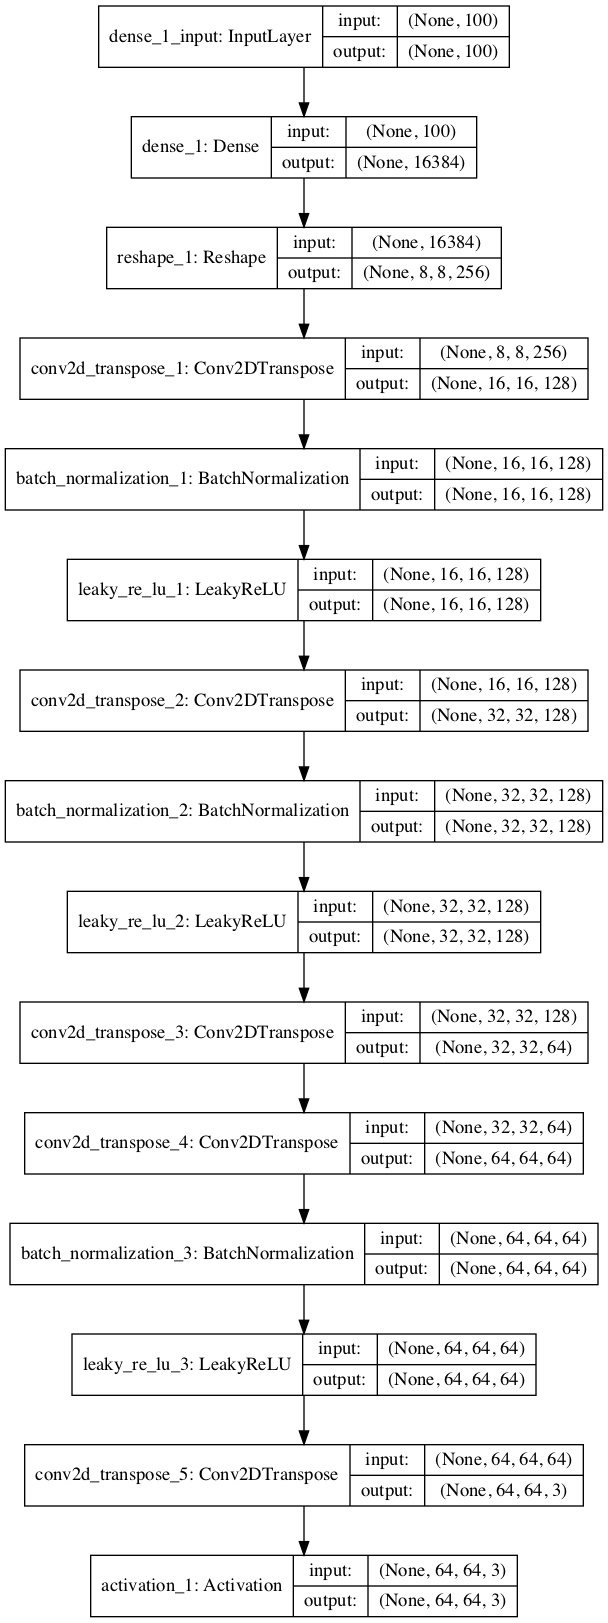

In [6]:
build_model = build_generator(z_dim)

plot_model(build_model, to_file="DCGAB_build_model.png", show_shapes=True)

## Discriminator

In [7]:
def build_discriminator(img_shape):

    model = Sequential()

    # 64x64x3(入力画像) を32x32x32のテンソルにする畳み込み層
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same')) #padding=sameにすると、入力の大きさをstridesの大きさで単純に割ったもの(28/2=14)が出力の大きさになる

    # Leaky ReLUによる活性化(最初の層にはバッチ正規化は適用しない)
    model.add(LeakyReLU(alpha=0.01))

    # 32x32x32 を16x16x64のテンソルにする畳み込み層
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLUによる活性化
    model.add(LeakyReLU(alpha=0.01))

    # 16x16x64 を8x8x128のテンソルにする畳み込み層
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # バッチ正規化
    model.add(BatchNormalization())

    # Leaky ReLU活性化
    model.add(LeakyReLU(alpha=0.01))

    # シグモイド関数で出力（０～１）
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

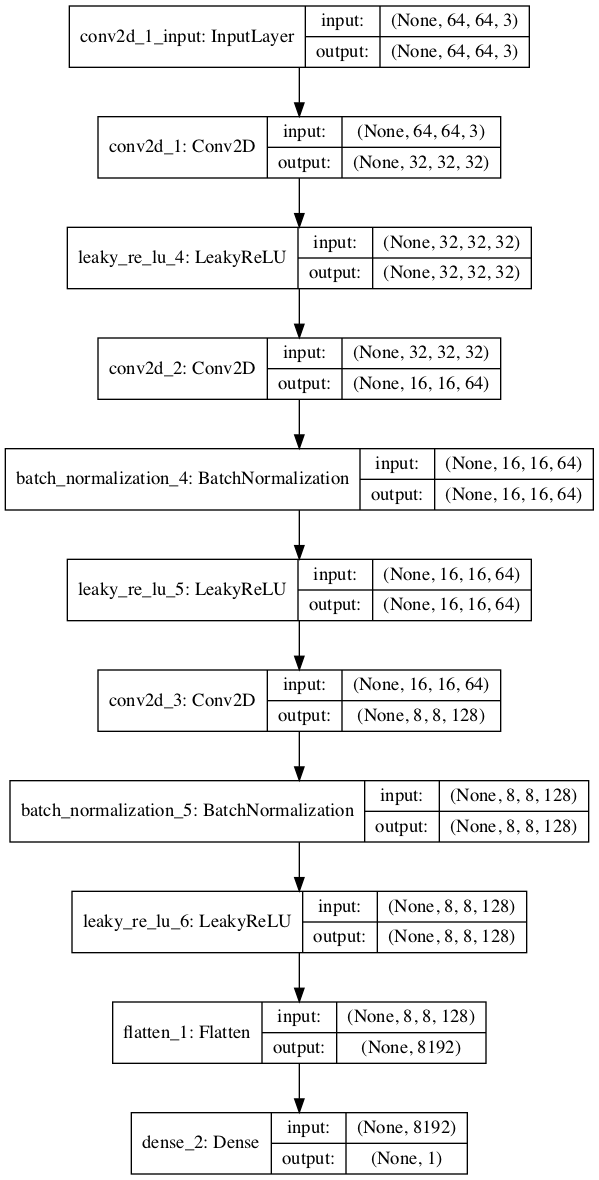

In [8]:
discriminator_model = build_discriminator(img_shape)

plot_model(discriminator_model, to_file="DCGAB_discriminator_model.png", show_shapes=True)

In [9]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 生成器と識別機を結合
    model.add(generator)
    model.add(discriminator)

    return model

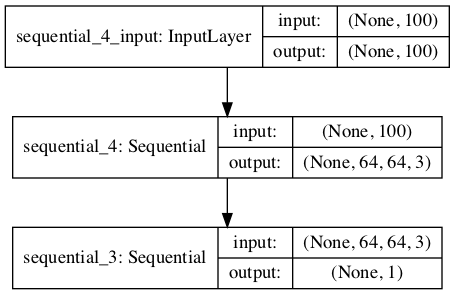

In [10]:
discriminator = build_discriminator(img_shape)
generator = build_generator(z_dim)
gan_model = build_gan(generator, discriminator)

plot_model(gan_model, to_file="DCGAB_gan_model.png", show_shapes=True)

In [11]:
# 識別機の生成とコンパイル
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

#前回学習の重みをロード
if train_iterates > 0:
    weights_path_1 = 'dcgan/models/D/d_model-' + str(train_iterates) + '.h5'
    discriminator.load_weights(weights_path_1)

# 生成器の生成
generator = build_generator(z_dim)

# 生成器の訓練時は識別機のパラメータを固定する
discriminator.trainable = False

# 識別機は固定のまま生成器を訓練するGANモデルの生成とコンパイル
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [12]:
#途中までの学習済みモデルのロード
from keras.models import load_model

model_g_dir = "dcgan/models/G"
model_d_dir = "dcgan/models/D"
if train_iterates > 0:
    models_path_1 = model_g_dir + '/g_param-' + str(train_iterates) + '.hdf5'
    generator.load_weights(models_path_1)

if train_iterates > 0:
    models_path_2 = model_g_dir + '/gan_param-' + str(train_iterates) + '.hdf5'
    gan.load_weights(models_path_2)

## Training

In [13]:
losses = []
accuracies = []
iteration_checkpoints = []
output_dir = "/Users/murakamikei/Desktop/GanPractice/dcgan/data"
model_g_dir = "/Users/murakamikei/Desktop/GanPractice/dcgan/models/G"
model_d_dir = "/Users/murakamikei/Desktop/GanPractice/dcgan/models/D"
num_of_trials = train_iterates

def train(iterations, batch_size, sample_interval):
  # 学習するデータセットを読み込む
  datasets = np.load("/Users/murakamikei/Desktop/GanPractice/dcgan/data/result.npy")

  # ndary型に変換
  X_train = datasets # (2000, 64, 64, 3)

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.0
    
  # Labels for real images: all ones
  real = np.ones((batch_size, 1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))
  print("check-001")

  for iteration in range(iterations):

      # -------------------------
      #  Train the Discriminator
      # -------------------------
      print("iteration=", iteration)
      # Get a random batch of real images
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
       # Generate a batch of fake images
      z = np.random.normal(0, 1, (batch_size, 100))
      gen_imgs = generator.predict(z)
       # Train Discriminator
      d_loss_real = discriminator.train_on_batch(imgs, real)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
      d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
     
      
      # ---------------------
      #  Train the Generator
      # ---------------------

      # Generate a batch of fake images
      z = np.random.normal(0, 1, (batch_size, 100))
      gen_imgs = generator.predict(z)

      # Train Generator
      g_loss = gan.train_on_batch(z, real)

      # if (iteration + 1) % sample_interval == 0:
      if iteration % sample_interval == 0:
          # Save losses and accuracies so they can be plotted after training
          losses.append((d_loss, g_loss))
          accuracies.append(100.0 * accuracy)
          iteration_checkpoints.append(iteration + 1)

          # Output training progress
          print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

          # Output a sample of generated image
          sample_images(generator, iteration)
          #識別器のモデル保存
          d_model_file=os.path.join(model_d_dir, "d_model-" + str(iteration + num_of_trials) +  ".h5")
          d_param_file=os.path.join(model_d_dir, "d_param-" + str(iteration + num_of_trials) +  ".hdf5")
          discriminator.save(d_model_file)	
          discriminator.save_weights(d_param_file)
          
          #生成器のモデル保存
          g_model_file=os.path.join(model_g_dir, "g_model-" + str(iteration + num_of_trials) +  ".h5")
          g_param_file=os.path.join(model_g_dir, "g_param-" + str(iteration + num_of_trials) +  ".hdf5")
          generator.save(g_model_file)	
          generator.save_weights(g_param_file)
          gan_model_file=os.path.join(model_g_dir, "gan_model-" + str(iteration + num_of_trials) +  ".h5")
          gan_param_file=os.path.join(model_g_dir, "gan_param-" + str(iteration + num_of_trials) +  ".hdf5")

          gan.save(gan_model_file)	
          gan.save_weights(gan_param_file)
          
          



In [14]:
def sample_images(generator, iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)  # (16, 64, 64, 3)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    print("生成されている画像の枚数とサイズ", gen_imgs.shape)
    # print("gen_imgs_type=", type(gen_imgs.shape))
    print("生成されている一枚一枚の画像サイズ=", gen_imgs[0,:,:,:].shape)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            print("shape=",gen_imgs[cnt, :, :, :].shape)
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    #file保存
    output_file = os.path.join(output_dir, 'result_' + str(iteration + num_of_trials) +'.png')
    plt.savefig(output_file)


In [ ]:
# Set hyperparameters

batch_size = 64

iterations =  50000
sample_interval = 100

if train_iterates > 0:
    iterations = 20000
    sample_interval = 100


# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

check-001
iteration= 0
Instructions for updating:
Use tf.cast instead.


/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 1.339406, acc.: 37.50%] [G loss: 0.039335]
生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 1
iteration= 2
iteration= 3
iteration= 4
iteration= 5
iteration= 6
iteration= 7
iteration= 8
iteration= 9
iteration= 10
iteration= 11
iteration= 12
iteration= 13
iteration= 14
iteration= 15
iteration= 16
iteration= 17
iteration= 18
iteration= 19
iteration= 20
iteration= 21
iteration= 22
iteration= 23
iteration= 24
iteration= 25
iteration= 26
iteration= 27
iteration= 28
iteration= 29
iteration= 30
iteration= 31
iteration= 32
iteration= 33
iteration= 34
iteration= 35
iteration= 36
iteration= 37
iteration= 38
iteration= 39
iteration= 40
iteration= 41
iteration= 42

iteration= 413
iteration= 414
iteration= 415
iteration= 416
iteration= 417
iteration= 418
iteration= 419
iteration= 420
iteration= 421
iteration= 422
iteration= 423
iteration= 424
iteration= 425
iteration= 426
iteration= 427
iteration= 428
iteration= 429
iteration= 430
iteration= 431
iteration= 432
iteration= 433
iteration= 434
iteration= 435
iteration= 436
iteration= 437
iteration= 438
iteration= 439
iteration= 440
iteration= 441
iteration= 442
iteration= 443
iteration= 444
iteration= 445
iteration= 446
iteration= 447
iteration= 448
iteration= 449
iteration= 450
iteration= 451
iteration= 452
iteration= 453
iteration= 454
iteration= 455
iteration= 456
iteration= 457
iteration= 458
iteration= 459
iteration= 460
iteration= 461
iteration= 462
iteration= 463
iteration= 464
iteration= 465
iteration= 466
iteration= 467
iteration= 468
iteration= 469
iteration= 470
iteration= 471
iteration= 472
iteration= 473
iteration= 474
iteration= 475
iteration= 476
iteration= 477
iteration= 478
iteration=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 501
iteration= 502
iteration= 503
iteration= 504
iteration= 505
iteration= 506
iteration= 507
iteration= 508
iteration= 509
iteration= 510
iteration= 511
iteration= 512
iteration= 513
iteration= 514
iteration= 515
iteration= 516
iteration= 517
iteration= 518
iteration= 519
iteration= 520
iteration= 521
iteration= 522
iteration= 523
iteration= 524
iteration= 525
iteration= 526
iteration= 527
iteration= 528
iteration= 529
iteration= 530
iteration= 531
iteration= 532
iteration= 533
iteration= 534
iteration= 535
iteration= 536
iteration= 537
iteration= 538
iteration= 539
iteration= 540
iteration= 541
iteration= 542
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 601
iteration= 602
iteration= 603
iteration= 604
iteration= 605
iteration= 606
iteration= 607
iteration= 608
iteration= 609
iteration= 610
iteration= 611
iteration= 612
iteration= 613
iteration= 614
iteration= 615
iteration= 616
iteration= 617
iteration= 618
iteration= 619
iteration= 620
iteration= 621
iteration= 622
iteration= 623
iteration= 624
iteration= 625
iteration= 626
iteration= 627
iteration= 628
iteration= 629
iteration= 630
iteration= 631
iteration= 632
iteration= 633
iteration= 634
iteration= 635
iteration= 636
iteration= 637
iteration= 638
iteration= 639
iteration= 640
iteration= 641
iteration= 642
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 701
iteration= 702
iteration= 703
iteration= 704
iteration= 705
iteration= 706
iteration= 707
iteration= 708
iteration= 709
iteration= 710
iteration= 711
iteration= 712
iteration= 713
iteration= 714
iteration= 715
iteration= 716
iteration= 717
iteration= 718
iteration= 719
iteration= 720
iteration= 721
iteration= 722
iteration= 723
iteration= 724
iteration= 725
iteration= 726
iteration= 727
iteration= 728
iteration= 729
iteration= 730
iteration= 731
iteration= 732
iteration= 733
iteration= 734
iteration= 735
iteration= 736
iteration= 737
iteration= 738
iteration= 739
iteration= 740
iteration= 741
iteration= 742
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 801
iteration= 802
iteration= 803
iteration= 804
iteration= 805
iteration= 806
iteration= 807
iteration= 808
iteration= 809
iteration= 810
iteration= 811
iteration= 812
iteration= 813
iteration= 814
iteration= 815
iteration= 816
iteration= 817
iteration= 818
iteration= 819
iteration= 820
iteration= 821
iteration= 822
iteration= 823
iteration= 824
iteration= 825
iteration= 826
iteration= 827
iteration= 828
iteration= 829
iteration= 830
iteration= 831
iteration= 832
iteration= 833
iteration= 834
iteration= 835
iteration= 836
iteration= 837
iteration= 838
iteration= 839
iteration= 840
iteration= 841
iteration= 842
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 901
iteration= 902
iteration= 903
iteration= 904
iteration= 905
iteration= 906
iteration= 907
iteration= 908
iteration= 909
iteration= 910
iteration= 911
iteration= 912
iteration= 913
iteration= 914
iteration= 915
iteration= 916
iteration= 917
iteration= 918
iteration= 919
iteration= 920
iteration= 921
iteration= 922
iteration= 923
iteration= 924
iteration= 925
iteration= 926
iteration= 927
iteration= 928
iteration= 929
iteration= 930
iteration= 931
iteration= 932
iteration= 933
iteration= 934
iteration= 935
iteration= 936
iteration= 937
iteration= 938
iteration= 939
iteration= 940
iteration= 941
iteration= 942
it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 1001
iteration= 1002
iteration= 1003
iteration= 1004
iteration= 1005
iteration= 1006
iteration= 1007
iteration= 1008
iteration= 1009
iteration= 1010
iteration= 1011
iteration= 1012
iteration= 1013
iteration= 1014
iteration= 1015
iteration= 1016
iteration= 1017
iteration= 1018
iteration= 1019
iteration= 1020
iteration= 1021
iteration= 1022
iteration= 1023
iteration= 1024
iteration= 1025
iteration= 1026
iteration= 1027
iteration= 1028
iteration= 1029
iteration= 1030
iteration= 1031
iteration= 1032
iteration= 1033
iteration= 1034
iteration= 1035
iteration= 1036
iteration= 1037
iteration= 1038
iteration= 1039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 1101
iteration= 1102
iteration= 1103
iteration= 1104
iteration= 1105
iteration= 1106
iteration= 1107
iteration= 1108
iteration= 1109
iteration= 1110
iteration= 1111
iteration= 1112
iteration= 1113
iteration= 1114
iteration= 1115
iteration= 1116
iteration= 1117
iteration= 1118
iteration= 1119
iteration= 1120
iteration= 1121
iteration= 1122
iteration= 1123
iteration= 1124
iteration= 1125
iteration= 1126
iteration= 1127
iteration= 1128
iteration= 1129
iteration= 1130
iteration= 1131
iteration= 1132
iteration= 1133
iteration= 1134
iteration= 1135
iteration= 1136
iteration= 1137
iteration= 1138
iteration= 1139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 1301
iteration= 1302
iteration= 1303
iteration= 1304
iteration= 1305
iteration= 1306
iteration= 1307
iteration= 1308
iteration= 1309
iteration= 1310
iteration= 1311
iteration= 1312
iteration= 1313
iteration= 1314
iteration= 1315
iteration= 1316
iteration= 1317
iteration= 1318
iteration= 1319
iteration= 1320
iteration= 1321
iteration= 1322
iteration= 1323
iteration= 1324
iteration= 1325
iteration= 1326
iteration= 1327
iteration= 1328
iteration= 1329
iteration= 1330
iteration= 1331
iteration= 1332
iteration= 1333
iteration= 1334
iteration= 1335
iteration= 1336
iteration= 1337
iteration= 1338
iteration= 1339
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 1701
iteration= 1702
iteration= 1703
iteration= 1704
iteration= 1705
iteration= 1706
iteration= 1707
iteration= 1708
iteration= 1709
iteration= 1710
iteration= 1711
iteration= 1712
iteration= 1713
iteration= 1714
iteration= 1715
iteration= 1716
iteration= 1717
iteration= 1718
iteration= 1719
iteration= 1720
iteration= 1721
iteration= 1722
iteration= 1723
iteration= 1724
iteration= 1725
iteration= 1726
iteration= 1727
iteration= 1728
iteration= 1729
iteration= 1730
iteration= 1731
iteration= 1732
iteration= 1733
iteration= 1734
iteration= 1735
iteration= 1736
iteration= 1737
iteration= 1738
iteration= 1739
iteratio

/Users/murakamikei/opt/anaconda3/envs/dcgan/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2001
iteration= 2002
iteration= 2003
iteration= 2004
iteration= 2005
iteration= 2006
iteration= 2007
iteration= 2008
iteration= 2009
iteration= 2010
iteration= 2011
iteration= 2012
iteration= 2013
iteration= 2014
iteration= 2015
iteration= 2016
iteration= 2017
iteration= 2018
iteration= 2019
iteration= 2020
iteration= 2021
iteration= 2022
iteration= 2023
iteration= 2024
iteration= 2025
iteration= 2026
iteration= 2027
iteration= 2028
iteration= 2029
iteration= 2030
iteration= 2031
iteration= 2032
iteration= 2033
iteration= 2034
iteration= 2035
iteration= 2036
iteration= 2037
iteration= 2038
iteration= 2039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2401
iteration= 2402
iteration= 2403
iteration= 2404
iteration= 2405
iteration= 2406
iteration= 2407
iteration= 2408
iteration= 2409
iteration= 2410
iteration= 2411
iteration= 2412
iteration= 2413
iteration= 2414
iteration= 2415
iteration= 2416
iteration= 2417
iteration= 2418
iteration= 2419
iteration= 2420
iteration= 2421
iteration= 2422
iteration= 2423
iteration= 2424
iteration= 2425
iteration= 2426
iteration= 2427
iteration= 2428
iteration= 2429
iteration= 2430
iteration= 2431
iteration= 2432
iteration= 2433
iteration= 2434
iteration= 2435
iteration= 2436
iteration= 2437
iteration= 2438
iteration= 2439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2501
iteration= 2502
iteration= 2503
iteration= 2504
iteration= 2505
iteration= 2506
iteration= 2507
iteration= 2508
iteration= 2509
iteration= 2510
iteration= 2511
iteration= 2512
iteration= 2513
iteration= 2514
iteration= 2515
iteration= 2516
iteration= 2517
iteration= 2518
iteration= 2519
iteration= 2520
iteration= 2521
iteration= 2522
iteration= 2523
iteration= 2524
iteration= 2525
iteration= 2526
iteration= 2527
iteration= 2528
iteration= 2529
iteration= 2530
iteration= 2531
iteration= 2532
iteration= 2533
iteration= 2534
iteration= 2535
iteration= 2536
iteration= 2537
iteration= 2538
iteration= 2539
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2601
iteration= 2602
iteration= 2603
iteration= 2604
iteration= 2605
iteration= 2606
iteration= 2607
iteration= 2608
iteration= 2609
iteration= 2610
iteration= 2611
iteration= 2612
iteration= 2613
iteration= 2614
iteration= 2615
iteration= 2616
iteration= 2617
iteration= 2618
iteration= 2619
iteration= 2620
iteration= 2621
iteration= 2622
iteration= 2623
iteration= 2624
iteration= 2625
iteration= 2626
iteration= 2627
iteration= 2628
iteration= 2629
iteration= 2630
iteration= 2631
iteration= 2632
iteration= 2633
iteration= 2634
iteration= 2635
iteration= 2636
iteration= 2637
iteration= 2638
iteration= 2639
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2701
iteration= 2702
iteration= 2703
iteration= 2704
iteration= 2705
iteration= 2706
iteration= 2707
iteration= 2708
iteration= 2709
iteration= 2710
iteration= 2711
iteration= 2712
iteration= 2713
iteration= 2714
iteration= 2715
iteration= 2716
iteration= 2717
iteration= 2718
iteration= 2719
iteration= 2720
iteration= 2721
iteration= 2722
iteration= 2723
iteration= 2724
iteration= 2725
iteration= 2726
iteration= 2727
iteration= 2728
iteration= 2729
iteration= 2730
iteration= 2731
iteration= 2732
iteration= 2733
iteration= 2734
iteration= 2735
iteration= 2736
iteration= 2737
iteration= 2738
iteration= 2739
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2801
iteration= 2802
iteration= 2803
iteration= 2804
iteration= 2805
iteration= 2806
iteration= 2807
iteration= 2808
iteration= 2809
iteration= 2810
iteration= 2811
iteration= 2812
iteration= 2813
iteration= 2814
iteration= 2815
iteration= 2816
iteration= 2817
iteration= 2818
iteration= 2819
iteration= 2820
iteration= 2821
iteration= 2822
iteration= 2823
iteration= 2824
iteration= 2825
iteration= 2826
iteration= 2827
iteration= 2828
iteration= 2829
iteration= 2830
iteration= 2831
iteration= 2832
iteration= 2833
iteration= 2834
iteration= 2835
iteration= 2836
iteration= 2837
iteration= 2838
iteration= 2839
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 2901
iteration= 2902
iteration= 2903
iteration= 2904
iteration= 2905
iteration= 2906
iteration= 2907
iteration= 2908
iteration= 2909
iteration= 2910
iteration= 2911
iteration= 2912
iteration= 2913
iteration= 2914
iteration= 2915
iteration= 2916
iteration= 2917
iteration= 2918
iteration= 2919
iteration= 2920
iteration= 2921
iteration= 2922
iteration= 2923
iteration= 2924
iteration= 2925
iteration= 2926
iteration= 2927
iteration= 2928
iteration= 2929
iteration= 2930
iteration= 2931
iteration= 2932
iteration= 2933
iteration= 2934
iteration= 2935
iteration= 2936
iteration= 2937
iteration= 2938
iteration= 2939
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3001
iteration= 3002
iteration= 3003
iteration= 3004
iteration= 3005
iteration= 3006
iteration= 3007
iteration= 3008
iteration= 3009
iteration= 3010
iteration= 3011
iteration= 3012
iteration= 3013
iteration= 3014
iteration= 3015
iteration= 3016
iteration= 3017
iteration= 3018
iteration= 3019
iteration= 3020
iteration= 3021
iteration= 3022
iteration= 3023
iteration= 3024
iteration= 3025
iteration= 3026
iteration= 3027
iteration= 3028
iteration= 3029
iteration= 3030
iteration= 3031
iteration= 3032
iteration= 3033
iteration= 3034
iteration= 3035
iteration= 3036
iteration= 3037
iteration= 3038
iteration= 3039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3101
iteration= 3102
iteration= 3103
iteration= 3104
iteration= 3105
iteration= 3106
iteration= 3107
iteration= 3108
iteration= 3109
iteration= 3110
iteration= 3111
iteration= 3112
iteration= 3113
iteration= 3114
iteration= 3115
iteration= 3116
iteration= 3117
iteration= 3118
iteration= 3119
iteration= 3120
iteration= 3121
iteration= 3122
iteration= 3123
iteration= 3124
iteration= 3125
iteration= 3126
iteration= 3127
iteration= 3128
iteration= 3129
iteration= 3130
iteration= 3131
iteration= 3132
iteration= 3133
iteration= 3134
iteration= 3135
iteration= 3136
iteration= 3137
iteration= 3138
iteration= 3139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3201
iteration= 3202
iteration= 3203
iteration= 3204
iteration= 3205
iteration= 3206
iteration= 3207
iteration= 3208
iteration= 3209
iteration= 3210
iteration= 3211
iteration= 3212
iteration= 3213
iteration= 3214
iteration= 3215
iteration= 3216
iteration= 3217
iteration= 3218
iteration= 3219
iteration= 3220
iteration= 3221
iteration= 3222
iteration= 3223
iteration= 3224
iteration= 3225
iteration= 3226
iteration= 3227
iteration= 3228
iteration= 3229
iteration= 3230
iteration= 3231
iteration= 3232
iteration= 3233
iteration= 3234
iteration= 3235
iteration= 3236
iteration= 3237
iteration= 3238
iteration= 3239
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3301
iteration= 3302
iteration= 3303
iteration= 3304
iteration= 3305
iteration= 3306
iteration= 3307
iteration= 3308
iteration= 3309
iteration= 3310
iteration= 3311
iteration= 3312
iteration= 3313
iteration= 3314
iteration= 3315
iteration= 3316
iteration= 3317
iteration= 3318
iteration= 3319
iteration= 3320
iteration= 3321
iteration= 3322
iteration= 3323
iteration= 3324
iteration= 3325
iteration= 3326
iteration= 3327
iteration= 3328
iteration= 3329
iteration= 3330
iteration= 3331
iteration= 3332
iteration= 3333
iteration= 3334
iteration= 3335
iteration= 3336
iteration= 3337
iteration= 3338
iteration= 3339
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3401
iteration= 3402
iteration= 3403
iteration= 3404
iteration= 3405
iteration= 3406
iteration= 3407
iteration= 3408
iteration= 3409
iteration= 3410
iteration= 3411
iteration= 3412
iteration= 3413
iteration= 3414
iteration= 3415
iteration= 3416
iteration= 3417
iteration= 3418
iteration= 3419
iteration= 3420
iteration= 3421
iteration= 3422
iteration= 3423
iteration= 3424
iteration= 3425
iteration= 3426
iteration= 3427
iteration= 3428
iteration= 3429
iteration= 3430
iteration= 3431
iteration= 3432
iteration= 3433
iteration= 3434
iteration= 3435
iteration= 3436
iteration= 3437
iteration= 3438
iteration= 3439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3501
iteration= 3502
iteration= 3503
iteration= 3504
iteration= 3505
iteration= 3506
iteration= 3507
iteration= 3508
iteration= 3509
iteration= 3510
iteration= 3511
iteration= 3512
iteration= 3513
iteration= 3514
iteration= 3515
iteration= 3516
iteration= 3517
iteration= 3518
iteration= 3519
iteration= 3520
iteration= 3521
iteration= 3522
iteration= 3523
iteration= 3524
iteration= 3525
iteration= 3526
iteration= 3527
iteration= 3528
iteration= 3529
iteration= 3530
iteration= 3531
iteration= 3532
iteration= 3533
iteration= 3534
iteration= 3535
iteration= 3536
iteration= 3537
iteration= 3538
iteration= 3539
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3601
iteration= 3602
iteration= 3603
iteration= 3604
iteration= 3605
iteration= 3606
iteration= 3607
iteration= 3608
iteration= 3609
iteration= 3610
iteration= 3611
iteration= 3612
iteration= 3613
iteration= 3614
iteration= 3615
iteration= 3616
iteration= 3617
iteration= 3618
iteration= 3619
iteration= 3620
iteration= 3621
iteration= 3622
iteration= 3623
iteration= 3624
iteration= 3625
iteration= 3626
iteration= 3627
iteration= 3628
iteration= 3629
iteration= 3630
iteration= 3631
iteration= 3632
iteration= 3633
iteration= 3634
iteration= 3635
iteration= 3636
iteration= 3637
iteration= 3638
iteration= 3639
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3701
iteration= 3702
iteration= 3703
iteration= 3704
iteration= 3705
iteration= 3706
iteration= 3707
iteration= 3708
iteration= 3709
iteration= 3710
iteration= 3711
iteration= 3712
iteration= 3713
iteration= 3714
iteration= 3715
iteration= 3716
iteration= 3717
iteration= 3718
iteration= 3719
iteration= 3720
iteration= 3721
iteration= 3722
iteration= 3723
iteration= 3724
iteration= 3725
iteration= 3726
iteration= 3727
iteration= 3728
iteration= 3729
iteration= 3730
iteration= 3731
iteration= 3732
iteration= 3733
iteration= 3734
iteration= 3735
iteration= 3736
iteration= 3737
iteration= 3738
iteration= 3739
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3801
iteration= 3802
iteration= 3803
iteration= 3804
iteration= 3805
iteration= 3806
iteration= 3807
iteration= 3808
iteration= 3809
iteration= 3810
iteration= 3811
iteration= 3812
iteration= 3813
iteration= 3814
iteration= 3815
iteration= 3816
iteration= 3817
iteration= 3818
iteration= 3819
iteration= 3820
iteration= 3821
iteration= 3822
iteration= 3823
iteration= 3824
iteration= 3825
iteration= 3826
iteration= 3827
iteration= 3828
iteration= 3829
iteration= 3830
iteration= 3831
iteration= 3832
iteration= 3833
iteration= 3834
iteration= 3835
iteration= 3836
iteration= 3837
iteration= 3838
iteration= 3839
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 3901
iteration= 3902
iteration= 3903
iteration= 3904
iteration= 3905
iteration= 3906
iteration= 3907
iteration= 3908
iteration= 3909
iteration= 3910
iteration= 3911
iteration= 3912
iteration= 3913
iteration= 3914
iteration= 3915
iteration= 3916
iteration= 3917
iteration= 3918
iteration= 3919
iteration= 3920
iteration= 3921
iteration= 3922
iteration= 3923
iteration= 3924
iteration= 3925
iteration= 3926
iteration= 3927
iteration= 3928
iteration= 3929
iteration= 3930
iteration= 3931
iteration= 3932
iteration= 3933
iteration= 3934
iteration= 3935
iteration= 3936
iteration= 3937
iteration= 3938
iteration= 3939
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4001
iteration= 4002
iteration= 4003
iteration= 4004
iteration= 4005
iteration= 4006
iteration= 4007
iteration= 4008
iteration= 4009
iteration= 4010
iteration= 4011
iteration= 4012
iteration= 4013
iteration= 4014
iteration= 4015
iteration= 4016
iteration= 4017
iteration= 4018
iteration= 4019
iteration= 4020
iteration= 4021
iteration= 4022
iteration= 4023
iteration= 4024
iteration= 4025
iteration= 4026
iteration= 4027
iteration= 4028
iteration= 4029
iteration= 4030
iteration= 4031
iteration= 4032
iteration= 4033
iteration= 4034
iteration= 4035
iteration= 4036
iteration= 4037
iteration= 4038
iteration= 4039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4101
iteration= 4102
iteration= 4103
iteration= 4104
iteration= 4105
iteration= 4106
iteration= 4107
iteration= 4108
iteration= 4109
iteration= 4110
iteration= 4111
iteration= 4112
iteration= 4113
iteration= 4114
iteration= 4115
iteration= 4116
iteration= 4117
iteration= 4118
iteration= 4119
iteration= 4120
iteration= 4121
iteration= 4122
iteration= 4123
iteration= 4124
iteration= 4125
iteration= 4126
iteration= 4127
iteration= 4128
iteration= 4129
iteration= 4130
iteration= 4131
iteration= 4132
iteration= 4133
iteration= 4134
iteration= 4135
iteration= 4136
iteration= 4137
iteration= 4138
iteration= 4139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4201
iteration= 4202
iteration= 4203
iteration= 4204
iteration= 4205
iteration= 4206
iteration= 4207
iteration= 4208
iteration= 4209
iteration= 4210
iteration= 4211
iteration= 4212
iteration= 4213
iteration= 4214
iteration= 4215
iteration= 4216
iteration= 4217
iteration= 4218
iteration= 4219
iteration= 4220
iteration= 4221
iteration= 4222
iteration= 4223
iteration= 4224
iteration= 4225
iteration= 4226
iteration= 4227
iteration= 4228
iteration= 4229
iteration= 4230
iteration= 4231
iteration= 4232
iteration= 4233
iteration= 4234
iteration= 4235
iteration= 4236
iteration= 4237
iteration= 4238
iteration= 4239
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4301
iteration= 4302
iteration= 4303
iteration= 4304
iteration= 4305
iteration= 4306
iteration= 4307
iteration= 4308
iteration= 4309
iteration= 4310
iteration= 4311
iteration= 4312
iteration= 4313
iteration= 4314
iteration= 4315
iteration= 4316
iteration= 4317
iteration= 4318
iteration= 4319
iteration= 4320
iteration= 4321
iteration= 4322
iteration= 4323
iteration= 4324
iteration= 4325
iteration= 4326
iteration= 4327
iteration= 4328
iteration= 4329
iteration= 4330
iteration= 4331
iteration= 4332
iteration= 4333
iteration= 4334
iteration= 4335
iteration= 4336
iteration= 4337
iteration= 4338
iteration= 4339
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4401
iteration= 4402
iteration= 4403
iteration= 4404
iteration= 4405
iteration= 4406
iteration= 4407
iteration= 4408
iteration= 4409
iteration= 4410
iteration= 4411
iteration= 4412
iteration= 4413
iteration= 4414
iteration= 4415
iteration= 4416
iteration= 4417
iteration= 4418
iteration= 4419
iteration= 4420
iteration= 4421
iteration= 4422
iteration= 4423
iteration= 4424
iteration= 4425
iteration= 4426
iteration= 4427
iteration= 4428
iteration= 4429
iteration= 4430
iteration= 4431
iteration= 4432
iteration= 4433
iteration= 4434
iteration= 4435
iteration= 4436
iteration= 4437
iteration= 4438
iteration= 4439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4501
iteration= 4502
iteration= 4503
iteration= 4504
iteration= 4505
iteration= 4506
iteration= 4507
iteration= 4508
iteration= 4509
iteration= 4510
iteration= 4511
iteration= 4512
iteration= 4513
iteration= 4514
iteration= 4515
iteration= 4516
iteration= 4517
iteration= 4518
iteration= 4519
iteration= 4520
iteration= 4521
iteration= 4522
iteration= 4523
iteration= 4524
iteration= 4525
iteration= 4526
iteration= 4527
iteration= 4528
iteration= 4529
iteration= 4530
iteration= 4531
iteration= 4532
iteration= 4533
iteration= 4534
iteration= 4535
iteration= 4536
iteration= 4537
iteration= 4538
iteration= 4539
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4601
iteration= 4602
iteration= 4603
iteration= 4604
iteration= 4605
iteration= 4606
iteration= 4607
iteration= 4608
iteration= 4609
iteration= 4610
iteration= 4611
iteration= 4612
iteration= 4613
iteration= 4614
iteration= 4615
iteration= 4616
iteration= 4617
iteration= 4618
iteration= 4619
iteration= 4620
iteration= 4621
iteration= 4622
iteration= 4623
iteration= 4624
iteration= 4625
iteration= 4626
iteration= 4627
iteration= 4628
iteration= 4629
iteration= 4630
iteration= 4631
iteration= 4632
iteration= 4633
iteration= 4634
iteration= 4635
iteration= 4636
iteration= 4637
iteration= 4638
iteration= 4639
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4701
iteration= 4702
iteration= 4703
iteration= 4704
iteration= 4705
iteration= 4706
iteration= 4707
iteration= 4708
iteration= 4709
iteration= 4710
iteration= 4711
iteration= 4712
iteration= 4713
iteration= 4714
iteration= 4715
iteration= 4716
iteration= 4717
iteration= 4718
iteration= 4719
iteration= 4720
iteration= 4721
iteration= 4722
iteration= 4723
iteration= 4724
iteration= 4725
iteration= 4726
iteration= 4727
iteration= 4728
iteration= 4729
iteration= 4730
iteration= 4731
iteration= 4732
iteration= 4733
iteration= 4734
iteration= 4735
iteration= 4736
iteration= 4737
iteration= 4738
iteration= 4739
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4801
iteration= 4802
iteration= 4803
iteration= 4804
iteration= 4805
iteration= 4806
iteration= 4807
iteration= 4808
iteration= 4809
iteration= 4810
iteration= 4811
iteration= 4812
iteration= 4813
iteration= 4814
iteration= 4815
iteration= 4816
iteration= 4817
iteration= 4818
iteration= 4819
iteration= 4820
iteration= 4821
iteration= 4822
iteration= 4823
iteration= 4824
iteration= 4825
iteration= 4826
iteration= 4827
iteration= 4828
iteration= 4829
iteration= 4830
iteration= 4831
iteration= 4832
iteration= 4833
iteration= 4834
iteration= 4835
iteration= 4836
iteration= 4837
iteration= 4838
iteration= 4839
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 4901
iteration= 4902
iteration= 4903
iteration= 4904
iteration= 4905
iteration= 4906
iteration= 4907
iteration= 4908
iteration= 4909
iteration= 4910
iteration= 4911
iteration= 4912
iteration= 4913
iteration= 4914
iteration= 4915
iteration= 4916
iteration= 4917
iteration= 4918
iteration= 4919
iteration= 4920
iteration= 4921
iteration= 4922
iteration= 4923
iteration= 4924
iteration= 4925
iteration= 4926
iteration= 4927
iteration= 4928
iteration= 4929
iteration= 4930
iteration= 4931
iteration= 4932
iteration= 4933
iteration= 4934
iteration= 4935
iteration= 4936
iteration= 4937
iteration= 4938
iteration= 4939
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5001
iteration= 5002
iteration= 5003
iteration= 5004
iteration= 5005
iteration= 5006
iteration= 5007
iteration= 5008
iteration= 5009
iteration= 5010
iteration= 5011
iteration= 5012
iteration= 5013
iteration= 5014
iteration= 5015
iteration= 5016
iteration= 5017
iteration= 5018
iteration= 5019
iteration= 5020
iteration= 5021
iteration= 5022
iteration= 5023
iteration= 5024
iteration= 5025
iteration= 5026
iteration= 5027
iteration= 5028
iteration= 5029
iteration= 5030
iteration= 5031
iteration= 5032
iteration= 5033
iteration= 5034
iteration= 5035
iteration= 5036
iteration= 5037
iteration= 5038
iteration= 5039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5101
iteration= 5102
iteration= 5103
iteration= 5104
iteration= 5105
iteration= 5106
iteration= 5107
iteration= 5108
iteration= 5109
iteration= 5110
iteration= 5111
iteration= 5112
iteration= 5113
iteration= 5114
iteration= 5115
iteration= 5116
iteration= 5117
iteration= 5118
iteration= 5119
iteration= 5120
iteration= 5121
iteration= 5122
iteration= 5123
iteration= 5124
iteration= 5125
iteration= 5126
iteration= 5127
iteration= 5128
iteration= 5129
iteration= 5130
iteration= 5131
iteration= 5132
iteration= 5133
iteration= 5134
iteration= 5135
iteration= 5136
iteration= 5137
iteration= 5138
iteration= 5139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5201
iteration= 5202
iteration= 5203
iteration= 5204
iteration= 5205
iteration= 5206
iteration= 5207
iteration= 5208
iteration= 5209
iteration= 5210
iteration= 5211
iteration= 5212
iteration= 5213
iteration= 5214
iteration= 5215
iteration= 5216
iteration= 5217
iteration= 5218
iteration= 5219
iteration= 5220
iteration= 5221
iteration= 5222
iteration= 5223
iteration= 5224
iteration= 5225
iteration= 5226
iteration= 5227
iteration= 5228
iteration= 5229
iteration= 5230
iteration= 5231
iteration= 5232
iteration= 5233
iteration= 5234
iteration= 5235
iteration= 5236
iteration= 5237
iteration= 5238
iteration= 5239
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5301
iteration= 5302
iteration= 5303
iteration= 5304
iteration= 5305
iteration= 5306
iteration= 5307
iteration= 5308
iteration= 5309
iteration= 5310
iteration= 5311
iteration= 5312
iteration= 5313
iteration= 5314
iteration= 5315
iteration= 5316
iteration= 5317
iteration= 5318
iteration= 5319
iteration= 5320
iteration= 5321
iteration= 5322
iteration= 5323
iteration= 5324
iteration= 5325
iteration= 5326
iteration= 5327
iteration= 5328
iteration= 5329
iteration= 5330
iteration= 5331
iteration= 5332
iteration= 5333
iteration= 5334
iteration= 5335
iteration= 5336
iteration= 5337
iteration= 5338
iteration= 5339
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5401
iteration= 5402
iteration= 5403
iteration= 5404
iteration= 5405
iteration= 5406
iteration= 5407
iteration= 5408
iteration= 5409
iteration= 5410
iteration= 5411
iteration= 5412
iteration= 5413
iteration= 5414
iteration= 5415
iteration= 5416
iteration= 5417
iteration= 5418
iteration= 5419
iteration= 5420
iteration= 5421
iteration= 5422
iteration= 5423
iteration= 5424
iteration= 5425
iteration= 5426
iteration= 5427
iteration= 5428
iteration= 5429
iteration= 5430
iteration= 5431
iteration= 5432
iteration= 5433
iteration= 5434
iteration= 5435
iteration= 5436
iteration= 5437
iteration= 5438
iteration= 5439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5501
iteration= 5502
iteration= 5503
iteration= 5504
iteration= 5505
iteration= 5506
iteration= 5507
iteration= 5508
iteration= 5509
iteration= 5510
iteration= 5511
iteration= 5512
iteration= 5513
iteration= 5514
iteration= 5515
iteration= 5516
iteration= 5517
iteration= 5518
iteration= 5519
iteration= 5520
iteration= 5521
iteration= 5522
iteration= 5523
iteration= 5524
iteration= 5525
iteration= 5526
iteration= 5527
iteration= 5528
iteration= 5529
iteration= 5530
iteration= 5531
iteration= 5532
iteration= 5533
iteration= 5534
iteration= 5535
iteration= 5536
iteration= 5537
iteration= 5538
iteration= 5539
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5601
iteration= 5602
iteration= 5603
iteration= 5604
iteration= 5605
iteration= 5606
iteration= 5607
iteration= 5608
iteration= 5609
iteration= 5610
iteration= 5611
iteration= 5612
iteration= 5613
iteration= 5614
iteration= 5615
iteration= 5616
iteration= 5617
iteration= 5618
iteration= 5619
iteration= 5620
iteration= 5621
iteration= 5622
iteration= 5623
iteration= 5624
iteration= 5625
iteration= 5626
iteration= 5627
iteration= 5628
iteration= 5629
iteration= 5630
iteration= 5631
iteration= 5632
iteration= 5633
iteration= 5634
iteration= 5635
iteration= 5636
iteration= 5637
iteration= 5638
iteration= 5639
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5701
iteration= 5702
iteration= 5703
iteration= 5704
iteration= 5705
iteration= 5706
iteration= 5707
iteration= 5708
iteration= 5709
iteration= 5710
iteration= 5711
iteration= 5712
iteration= 5713
iteration= 5714
iteration= 5715
iteration= 5716
iteration= 5717
iteration= 5718
iteration= 5719
iteration= 5720
iteration= 5721
iteration= 5722
iteration= 5723
iteration= 5724
iteration= 5725
iteration= 5726
iteration= 5727
iteration= 5728
iteration= 5729
iteration= 5730
iteration= 5731
iteration= 5732
iteration= 5733
iteration= 5734
iteration= 5735
iteration= 5736
iteration= 5737
iteration= 5738
iteration= 5739
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5801
iteration= 5802
iteration= 5803
iteration= 5804
iteration= 5805
iteration= 5806
iteration= 5807
iteration= 5808
iteration= 5809
iteration= 5810
iteration= 5811
iteration= 5812
iteration= 5813
iteration= 5814
iteration= 5815
iteration= 5816
iteration= 5817
iteration= 5818
iteration= 5819
iteration= 5820
iteration= 5821
iteration= 5822
iteration= 5823
iteration= 5824
iteration= 5825
iteration= 5826
iteration= 5827
iteration= 5828
iteration= 5829
iteration= 5830
iteration= 5831
iteration= 5832
iteration= 5833
iteration= 5834
iteration= 5835
iteration= 5836
iteration= 5837
iteration= 5838
iteration= 5839
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 5901
iteration= 5902
iteration= 5903
iteration= 5904
iteration= 5905
iteration= 5906
iteration= 5907
iteration= 5908
iteration= 5909
iteration= 5910
iteration= 5911
iteration= 5912
iteration= 5913
iteration= 5914
iteration= 5915
iteration= 5916
iteration= 5917
iteration= 5918
iteration= 5919
iteration= 5920
iteration= 5921
iteration= 5922
iteration= 5923
iteration= 5924
iteration= 5925
iteration= 5926
iteration= 5927
iteration= 5928
iteration= 5929
iteration= 5930
iteration= 5931
iteration= 5932
iteration= 5933
iteration= 5934
iteration= 5935
iteration= 5936
iteration= 5937
iteration= 5938
iteration= 5939
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6001
iteration= 6002
iteration= 6003
iteration= 6004
iteration= 6005
iteration= 6006
iteration= 6007
iteration= 6008
iteration= 6009
iteration= 6010
iteration= 6011
iteration= 6012
iteration= 6013
iteration= 6014
iteration= 6015
iteration= 6016
iteration= 6017
iteration= 6018
iteration= 6019
iteration= 6020
iteration= 6021
iteration= 6022
iteration= 6023
iteration= 6024
iteration= 6025
iteration= 6026
iteration= 6027
iteration= 6028
iteration= 6029
iteration= 6030
iteration= 6031
iteration= 6032
iteration= 6033
iteration= 6034
iteration= 6035
iteration= 6036
iteration= 6037
iteration= 6038
iteration= 6039
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6101
iteration= 6102
iteration= 6103
iteration= 6104
iteration= 6105
iteration= 6106
iteration= 6107
iteration= 6108
iteration= 6109
iteration= 6110
iteration= 6111
iteration= 6112
iteration= 6113
iteration= 6114
iteration= 6115
iteration= 6116
iteration= 6117
iteration= 6118
iteration= 6119
iteration= 6120
iteration= 6121
iteration= 6122
iteration= 6123
iteration= 6124
iteration= 6125
iteration= 6126
iteration= 6127
iteration= 6128
iteration= 6129
iteration= 6130
iteration= 6131
iteration= 6132
iteration= 6133
iteration= 6134
iteration= 6135
iteration= 6136
iteration= 6137
iteration= 6138
iteration= 6139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6201
iteration= 6202
iteration= 6203
iteration= 6204
iteration= 6205
iteration= 6206
iteration= 6207
iteration= 6208
iteration= 6209
iteration= 6210
iteration= 6211
iteration= 6212
iteration= 6213
iteration= 6214
iteration= 6215
iteration= 6216
iteration= 6217
iteration= 6218
iteration= 6219
iteration= 6220
iteration= 6221
iteration= 6222
iteration= 6223
iteration= 6224
iteration= 6225
iteration= 6226
iteration= 6227
iteration= 6228
iteration= 6229
iteration= 6230
iteration= 6231
iteration= 6232
iteration= 6233
iteration= 6234
iteration= 6235
iteration= 6236
iteration= 6237
iteration= 6238
iteration= 6239
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6301
iteration= 6302
iteration= 6303
iteration= 6304
iteration= 6305
iteration= 6306
iteration= 6307
iteration= 6308
iteration= 6309
iteration= 6310
iteration= 6311
iteration= 6312
iteration= 6313
iteration= 6314
iteration= 6315
iteration= 6316
iteration= 6317
iteration= 6318
iteration= 6319
iteration= 6320
iteration= 6321
iteration= 6322
iteration= 6323
iteration= 6324
iteration= 6325
iteration= 6326
iteration= 6327
iteration= 6328
iteration= 6329
iteration= 6330
iteration= 6331
iteration= 6332
iteration= 6333
iteration= 6334
iteration= 6335
iteration= 6336
iteration= 6337
iteration= 6338
iteration= 6339
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6401
iteration= 6402
iteration= 6403
iteration= 6404
iteration= 6405
iteration= 6406
iteration= 6407
iteration= 6408
iteration= 6409
iteration= 6410
iteration= 6411
iteration= 6412
iteration= 6413
iteration= 6414
iteration= 6415
iteration= 6416
iteration= 6417
iteration= 6418
iteration= 6419
iteration= 6420
iteration= 6421
iteration= 6422
iteration= 6423
iteration= 6424
iteration= 6425
iteration= 6426
iteration= 6427
iteration= 6428
iteration= 6429
iteration= 6430
iteration= 6431
iteration= 6432
iteration= 6433
iteration= 6434
iteration= 6435
iteration= 6436
iteration= 6437
iteration= 6438
iteration= 6439
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6501
iteration= 6502
iteration= 6503
iteration= 6504
iteration= 6505
iteration= 6506
iteration= 6507
iteration= 6508
iteration= 6509
iteration= 6510
iteration= 6511
iteration= 6512
iteration= 6513
iteration= 6514
iteration= 6515
iteration= 6516
iteration= 6517
iteration= 6518
iteration= 6519
iteration= 6520
iteration= 6521
iteration= 6522
iteration= 6523
iteration= 6524
iteration= 6525
iteration= 6526
iteration= 6527
iteration= 6528
iteration= 6529
iteration= 6530
iteration= 6531
iteration= 6532
iteration= 6533
iteration= 6534
iteration= 6535
iteration= 6536
iteration= 6537
iteration= 6538
iteration= 6539
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6601
iteration= 6602
iteration= 6603
iteration= 6604
iteration= 6605
iteration= 6606
iteration= 6607
iteration= 6608
iteration= 6609
iteration= 6610
iteration= 6611
iteration= 6612
iteration= 6613
iteration= 6614
iteration= 6615
iteration= 6616
iteration= 6617
iteration= 6618
iteration= 6619
iteration= 6620
iteration= 6621
iteration= 6622
iteration= 6623
iteration= 6624
iteration= 6625
iteration= 6626
iteration= 6627
iteration= 6628
iteration= 6629
iteration= 6630
iteration= 6631
iteration= 6632
iteration= 6633
iteration= 6634
iteration= 6635
iteration= 6636
iteration= 6637
iteration= 6638
iteration= 6639
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6701
iteration= 6702
iteration= 6703
iteration= 6704
iteration= 6705
iteration= 6706
iteration= 6707
iteration= 6708
iteration= 6709
iteration= 6710
iteration= 6711
iteration= 6712
iteration= 6713
iteration= 6714
iteration= 6715
iteration= 6716
iteration= 6717
iteration= 6718
iteration= 6719
iteration= 6720
iteration= 6721
iteration= 6722
iteration= 6723
iteration= 6724
iteration= 6725
iteration= 6726
iteration= 6727
iteration= 6728
iteration= 6729
iteration= 6730
iteration= 6731
iteration= 6732
iteration= 6733
iteration= 6734
iteration= 6735
iteration= 6736
iteration= 6737
iteration= 6738
iteration= 6739
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6801
iteration= 6802
iteration= 6803
iteration= 6804
iteration= 6805
iteration= 6806
iteration= 6807
iteration= 6808
iteration= 6809
iteration= 6810
iteration= 6811
iteration= 6812
iteration= 6813
iteration= 6814
iteration= 6815
iteration= 6816
iteration= 6817
iteration= 6818
iteration= 6819
iteration= 6820
iteration= 6821
iteration= 6822
iteration= 6823
iteration= 6824
iteration= 6825
iteration= 6826
iteration= 6827
iteration= 6828
iteration= 6829
iteration= 6830
iteration= 6831
iteration= 6832
iteration= 6833
iteration= 6834
iteration= 6835
iteration= 6836
iteration= 6837
iteration= 6838
iteration= 6839
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 6901
iteration= 6902
iteration= 6903
iteration= 6904
iteration= 6905
iteration= 6906
iteration= 6907
iteration= 6908
iteration= 6909
iteration= 6910
iteration= 6911
iteration= 6912
iteration= 6913
iteration= 6914
iteration= 6915
iteration= 6916
iteration= 6917
iteration= 6918
iteration= 6919
iteration= 6920
iteration= 6921
iteration= 6922
iteration= 6923
iteration= 6924
iteration= 6925
iteration= 6926
iteration= 6927
iteration= 6928
iteration= 6929
iteration= 6930
iteration= 6931
iteration= 6932
iteration= 6933
iteration= 6934
iteration= 6935
iteration= 6936
iteration= 6937
iteration= 6938
iteration= 6939
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7001
iteration= 7002
iteration= 7003
iteration= 7004
iteration= 7005
iteration= 7006
iteration= 7007
iteration= 7008
iteration= 7009
iteration= 7010
iteration= 7011
iteration= 7012
iteration= 7013
iteration= 7014
iteration= 7015
iteration= 7016
iteration= 7017
iteration= 7018
iteration= 7019
iteration= 7020
iteration= 7021
iteration= 7022
iteration= 7023
iteration= 7024
iteration= 7025
iteration= 7026
iteration= 7027
iteration= 7028
iteration= 7029
iteration= 7030
iteration= 7031
iteration= 7032
iteration= 7033
iteration= 7034
iteration= 7035
iteration= 7036
iteration= 7037
iteration= 7038
iteration= 7039
iteration= 7040
iteration= 7041
iteration= 7042
iteration= 7043
iteration= 7044
iteration= 7045
iteration= 7046
iteration= 7047
iteration= 7048
iteration= 7049
iteration= 7050
iteration= 7051
iteration= 7052
iteration= 7053
iteration= 7054
iteration= 7055
iteration= 7056
iteration= 7057
iteration= 7058
iteration= 7059

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7101
iteration= 7102
iteration= 7103
iteration= 7104
iteration= 7105
iteration= 7106
iteration= 7107
iteration= 7108
iteration= 7109
iteration= 7110
iteration= 7111
iteration= 7112
iteration= 7113
iteration= 7114
iteration= 7115
iteration= 7116
iteration= 7117
iteration= 7118
iteration= 7119
iteration= 7120
iteration= 7121
iteration= 7122
iteration= 7123
iteration= 7124
iteration= 7125
iteration= 7126
iteration= 7127
iteration= 7128
iteration= 7129
iteration= 7130
iteration= 7131
iteration= 7132
iteration= 7133
iteration= 7134
iteration= 7135
iteration= 7136
iteration= 7137
iteration= 7138
iteration= 7139
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7201
iteration= 7202
iteration= 7203
iteration= 7204
iteration= 7205
iteration= 7206
iteration= 7207
iteration= 7208
iteration= 7209
iteration= 7210
iteration= 7211
iteration= 7212
iteration= 7213
iteration= 7214
iteration= 7215
iteration= 7216
iteration= 7217
iteration= 7218
iteration= 7219
iteration= 7220
iteration= 7221
iteration= 7222
iteration= 7223
iteration= 7224
iteration= 7225
iteration= 7226
iteration= 7227
iteration= 7228
iteration= 7229
iteration= 7230
iteration= 7231
iteration= 7232
iteration= 7233
iteration= 7234
iteration= 7235
iteration= 7236
iteration= 7237
iteration= 7238
iteration= 7239
iteratio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape= (64, 64, 3)
iteration= 7301
iteration= 7302
iteration= 7303
iteration= 7304
iteration= 7305
iteration= 7306
iteration= 7307
iteration= 7308
iteration= 7309
iteration= 7310
iteration= 7311
iteration= 7312
iteration= 7313
iteration= 7314
iteration= 7315
iteration= 7316
iteration= 7317
iteration= 7318
iteration= 7319
iteration= 7320
iteration= 7321
iteration= 7322
iteration= 7323
iteration= 7324
iteration= 7325
iteration= 7326
iteration= 7327
iteration= 7328
iteration= 7329
iteration= 7330
iteration= 7331
iteration= 7332
iteration= 7333
iteration= 7334
iteration= 7335
iteration= 7336
iteration= 7337
iteration= 7338
iteration= 7339
iteration= 7340
iteration= 7341
iteration= 7342
iteration= 7343
iteration= 7344
iteration= 7345
iteration= 7346
iteration= 7347
iteration= 7348
iteration= 7349
iteration= 7350
iteration= 7351
iteration= 7352
iteration= 7353
iteration= 7354
iteration= 7355
iteration= 7356
iteration= 7357
iteration= 7358
iteration= 7359
iteration= 7360
iteration= 7361
itera

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


生成されている画像の枚数とサイズ (16, 64, 64, 3)
生成されている一枚一枚の画像サイズ= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
shape= (64, 64, 3)
iteration= 7401
iteration= 7402
iteration= 7403
iteration= 7404
iteration= 7405
iteration= 7406
iteration= 7407
iteration= 7408
iteration= 7409
iteration= 7410
iteration= 7411
iteration= 7412
iteration= 7413
iteration= 7414
iteration= 7415
iteration= 7416
iteration= 7417
iteration= 7418
iteration= 7419
iteration= 7420
iteration= 7421
iteration= 7422
iteration= 7423
iteration= 7424
iteration= 7425
iteration= 7426
iteration= 7427
iteration= 7428
iteration= 7429
iteration= 7430
iteration= 7431
iteration= 7432
iteration= 7433
